Imports:

In [1]:
#Imports necessários para o funcionamento da RNA
import os
import logging
import warnings
from matplotlib import pyplot as plt #type: ignore
import pandas as pd #type: ignore
from sklearn.model_selection import train_test_split #type: ignore
from sklearn.preprocessing import StandardScaler #type: ignore
from sklearn.metrics import roc_curve, auc #type: ignore
import tensorflow as tf #type: ignore
from tensorflow.keras.models import Sequential #type: ignore
from tensorflow.keras.layers import Dense, Dropout #type: ignore
from tensorflow.keras.optimizers import Adam #type: ignore
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report #type: ignore
import json


Carregamento dos dados e tratamento das informações:

In [2]:
#Ignorar mensagens desnecessárias no terminal durante o desenvolvimento em casos de erros (Como já está correto, estamos deixando ausente)
'''os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)'''

#Carregamento do arquivo do Banco de dados CSV 
file_path = os.path.join('data.csv')

if file_path:
    try:
        data = pd.read_csv(file_path)
    except Exception as e:
        print(f"Ocorreu um erro: {e}")

#Verificação visual caso exista algum dado ausente no Banco de Dados (Como já verificamos, estamos deixando ausente)
'''print("Dados ausentes por coluna:")
print(data.isnull().sum())'''

#Remover colunas desnecessárias
if 'Unnamed: 32' in data.columns:
    data = data.drop(columns=['Unnamed: 32'])
if 'id' in data.columns:
    ids = data['id']  
    data = data.drop(columns=['id'])

#Convertendo o diagnosis para valores 0 e 1, indicando Maligno e Benigno
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})

#Tratamento
if data.isnull().sum().sum() > 0:
    data = data.dropna()

#Divisão dos dados em características X e Y
X = data.drop(columns=['diagnosis'])
y = data['diagnosis']

Solicitando ao usuário escolher o conjunto de treinamento da rede:

In [3]:
#Solicitar ao usuário o tamanho do conjunto de treinamento para a rede neural (Finalidade de realizar 10 testes para verificarmos sua melhoria)
while True:
    try:
        test_size = float(input("Escolha o conjunto para treinamento (Valores entre 0 e 1): "))
        if 0 < test_size < 1:
            break
        else:
            print("Insira um valor entre 0 e 1. (Exemplo 0.8)")
    except ValueError:
        print("Valor inválido.")

test_size = 1 - test_size

Modelo de treinamento:

In [4]:
#Dividindo os dados para treinamento da rede
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

#Normalização dos dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_scaled = scaler.transform(X)   

#Modelo utilizando Relu e saída Sigmoid, pois foram os melhores resultados encontrados. 
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

#Compilando o modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

#Treinamento do modelo com 500 épocas para treino (Acreditamos ser o suficiente neste contexto)
history = model.fit(X_train, y_train, epochs=500, validation_split=0.2, batch_size=32, verbose=1, callbacks=[])

#Rodar o modelo treinado em cima de todos os dados (sem divisão de treino/teste)
y_pred_all = (model.predict(X_scaled) > 0.5).astype("int32")


Epoch 1/500


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.4246 - accuracy: 0.4038 - loss: 0.9552 - val_AUC: 0.2330 - val_accuracy: 0.3297 - val_loss: 0.8476
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.4585 - accuracy: 0.4302 - loss: 0.8554 - val_AUC: 0.2876 - val_accuracy: 0.3846 - val_loss: 0.8043
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.4327 - accuracy: 0.4476 - loss: 0.9097 - val_AUC: 0.3668 - val_accuracy: 0.4286 - val_loss: 0.7636
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.5196 - accuracy: 0.4731 - loss: 0.7986 - val_AUC: 0.4519 - val_accuracy: 0.5055 - val_loss: 0.7265
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.4778 - accuracy: 0.4616 - loss: 0.8225 - val_AUC: 0.5601 - val_accuracy: 0.5934 - val_loss: 0.6913
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.5571 - accuracy: 0.5227 - loss: 0.7585 - val_AUC: 0.6505 - val_accuracy: 0.6374 - val_loss: 0.6596
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC:

Avaliação do modelo utilizado:

In [5]:

#Avaliando o modelo
test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test, verbose=0)
y_pred_prob = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f'Acurácia: {test_accuracy:.4f}')
print(f'AUC: {test_auc:.4f}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Acurácia: 0.9825
AUC: 0.9957


Gráfico da acurácia e perda do treinamento gerados após a execução do código:

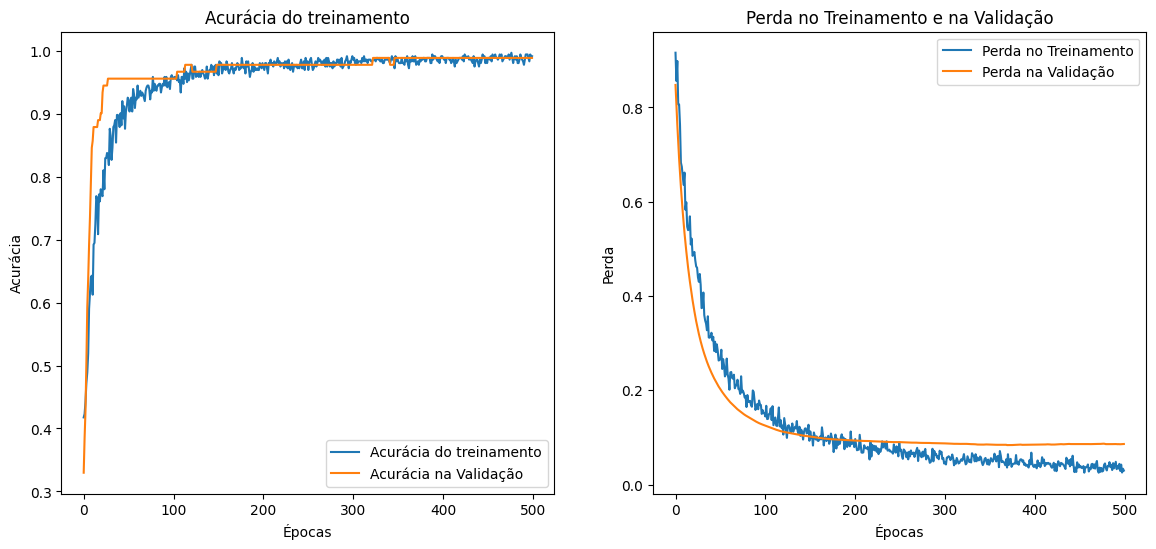

In [6]:
#Gráfico da acurácia
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia do treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia na Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.title('Acurácia do treinamento')

#Gráfico da Perda no treinamento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perda no Treinamento')
plt.plot(history.history['val_loss'], label='Perda na Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.title('Perda no Treinamento e na Validação')
plt.show()

Gráfico da validação do modelo, curva ROC:

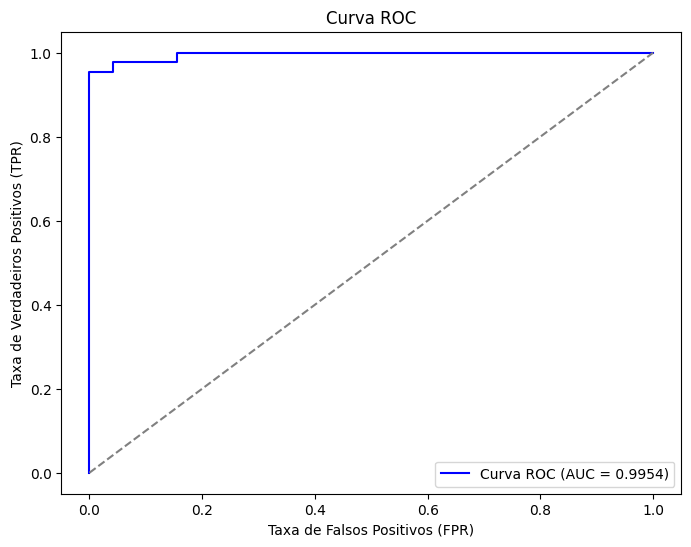

In [ ]:
#Gráfico da Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Linha de referência
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

Gráfico da Matriz de confusão gerado depois da execução do código:

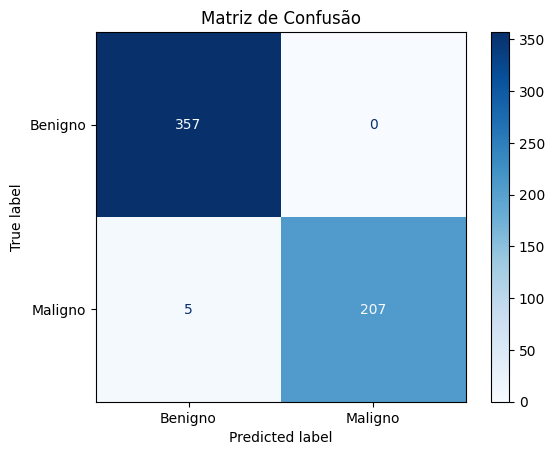

In [8]:
#Gráfico da Matriz de confusão
cm_all = confusion_matrix(y, y_pred_all)
disp_all = ConfusionMatrixDisplay(confusion_matrix=cm_all, display_labels=['Benigno', 'Maligno'])
disp_all.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.show()

Cálculos feitos manualmente:

In [9]:
#Contas para verificação e validação manual dos resultados (Somente para fins de testes)
verdadeiro_negativo, falso_positivo, falso_negativo, verdadeiro_positivo = cm_all.ravel()

#Contas para precisão Benigno, recall e f1
precision_benigno = verdadeiro_negativo / (verdadeiro_negativo + falso_negativo) if (verdadeiro_negativo + falso_negativo) > 0 else 0
recall_benigno = verdadeiro_negativo / (verdadeiro_negativo + falso_positivo) if (verdadeiro_negativo + falso_positivo) > 0 else 0
f1_benigno = 2 * (precision_benigno * recall_benigno) / (precision_benigno + recall_benigno) if (precision_benigno + recall_benigno) > 0 else 0

#Contas para precisão Maligno, recall e f1
precision_maligno = verdadeiro_positivo / (verdadeiro_positivo + falso_positivo) if (verdadeiro_positivo + falso_positivo) > 0 else 0
recall_maligno = verdadeiro_positivo / (verdadeiro_positivo + falso_negativo) if (verdadeiro_positivo + falso_negativo) > 0 else 0
f1_maligno = 2 * (precision_maligno * recall_maligno) / (precision_maligno + recall_maligno) if (precision_maligno + recall_maligno) > 0 else 0

#Visualiação visual das métricas encontradas 
print("|Métricas manuais calculadas com base na Matriz de Confusão|")
print(f"|Benigno | Precisão: {precision_benigno:.10f} | Recall: {recall_benigno:.10f} | F1-Score: {f1_benigno:.10f}|")
print(f"|Maligno | Precisão: {precision_maligno:.10f} | Recall: {recall_maligno:.10f} | F1-Score: {f1_maligno:.10f}|")

|Métricas manuais calculadas com base na Matriz de Confusão|
|Benigno | Precisão: 0.9861878453 | Recall: 1.0000000000 | F1-Score: 0.9930458971|
|Maligno | Precisão: 1.0000000000 | Recall: 0.9764150943 | F1-Score: 0.9880668258|


Geração do relatório, salvamento de informações e caminho especificado JSON:

In [10]:

#Relatório de classificação
classification_report_all = classification_report(y, y_pred_all, target_names=['Benigno', 'Maligno'], output_dict=True)
print("Relatório de Classificação:")
print(classification_report(y, y_pred_all, target_names=['Benigno', 'Maligno']))

#Informações para o JSON
results = {
    "test_evaluation": {
        "test_loss": test_loss,
        "test_accuracy": test_accuracy,
        "test_auc": test_auc,
        "classification_report": classification_report_all 
    },
    "all_data_evaluation": {
        "classification_report_all": classification_report_all,
        "confusion_matrix_all": cm_all.tolist()  
    }
}

#Caminho arquivo JSON
results_file_path = 'resultados.json'

#Carregar os resultados existentes e adicionar novos resultados encontrados no arquivo JSON (Informações para o artigo)
if os.path.exists(results_file_path):
    with open(results_file_path, 'r') as json_file:
        existing_results = json.load(json_file)
else:
    existing_results = []

#Adicionar os novos resultados da execução
existing_results.append(results)

#Salvar os resultados atualizados no JSON
with open(results_file_path, 'w') as json_file:
    json.dump(existing_results, json_file, indent=4)

#Indicando o local de salvamento dos resultados.
print(f"Resultados salvos em: {results_file_path}")

Relatório de Classificação:
              precision    recall  f1-score   support

     Benigno       0.99      1.00      0.99       357
     Maligno       1.00      0.98      0.99       212

    accuracy                           0.99       569
   macro avg       0.99      0.99      0.99       569
weighted avg       0.99      0.99      0.99       569

Resultados salvos em: resultados.json
